In [79]:
import pandas as pd
from operator import attrgetter
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/user_activity.csv')
# Asumiendo que ya cargaste df y tiene las columnas user_id, signup_date, activity_date
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['activity_date'] = pd.to_datetime(df['activity_date'])

# Crear cohort_month (mes del primer registro de cada usuario)
df['cohort_month'] = df.groupby('user_id')['signup_date'].transform('min').dt.to_period('M')

# Mes de actividad
df['activity_month'] = df['activity_date'].dt.to_period('M')

# Cohort index: meses desde registro (actividad - registro)
df['cohort_index'] = (df['activity_month'] - df['cohort_month']).apply(attrgetter('n'))

# Contar usuarios activos únicos por cohorte y mes relativo
df_unique = df.drop_duplicates(subset=['user_id', 'cohort_index'])
cohort_data = df_unique.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().reset_index()

# Pivot para obtener la matriz de usuarios activos
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='user_id')

# Tamaño inicial real de cada cohorte (usuarios únicos que se registraron en cada mes)
cohort_size = df.groupby('cohort_month')['user_id'].nunique()

# Matriz de retención: dividir por tamaño inicial
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

print("Tamaño de cohortes (mes 0):")
print(cohort_size)

print("\nMatriz de retención:")
print(retention)


Tamaño de cohortes (mes 0):
cohort_month
2024-01    386
2024-02    379
2024-03    333
2024-04    331
2024-05    280
Freq: M, Name: user_id, dtype: int64

Matriz de retención:
cohort_index      0      1      2      3      4
cohort_month                                   
2024-01       0.352  0.567  0.560  0.544  0.262
2024-02       0.301  0.554  0.554  0.528  0.293
2024-03       0.336  0.538  0.607  0.592    NaN
2024-04       0.420  0.628  0.650    NaN    NaN
2024-05       0.504  0.764    NaN    NaN    NaN


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Retención'})
plt.title('Matriz de Retención por Cohorte')
plt.xlabel('Meses desde Registro (Cohort Index)')
plt.ylabel('Cohorte (Mes de Registro)')
plt.tight_layout()  # Ajusta márgenes
plt.savefig('heatmap_retencion.png')  # Guarda como imagen PNG
plt.close()  # Cierra la figura (importante si hacés muchos gráficos)


In [83]:
retention.mean(axis=0).plot(marker='o')
plt.title('Retención promedio a lo largo del tiempo')
plt.xlabel('Meses desde Registro')
plt.ylabel('Retención promedio')
plt.grid(True)
plt.tight_layout()  # Evita que se corten etiquetas o títulos
plt.savefig('retencion_promedio_tiempo.png')  # Guarda como imagen
plt.close()  # Cierra la figura



In [84]:
# 1. Comparar cohortes antiguas vs recientes
# Pregunta: ¿Las cohortes más recientes tienen mejor o peor retención que las antiguas?

# Cómo hacerlo:

# Graficar la retención promedio por cohorte (media por fila).

# Ver si la curva sube, baja o se mantiene estable con el tiempo (meses de registro).

# Retención promedio por cohorte (fila)
cohort_retention = retention.mean(axis=1)

plt.figure(figsize=(10, 5))
cohort_retention.plot(marker='o')
plt.title("Retención Promedio por Cohorte (Mes de Registro)")
plt.xlabel("Cohorte (Mes de Registro)")
plt.ylabel("Retención promedio")
plt.grid(True)
plt.tight_layout()
plt.savefig('retencion_promedio_por_cohorte.png')
plt.close()


# Interpretación:

# Si las cohortes recientes tienen retención más alta, el producto o la experiencia mejoró.

# Si baja, puede haber problemas nuevos o pérdida de interés.


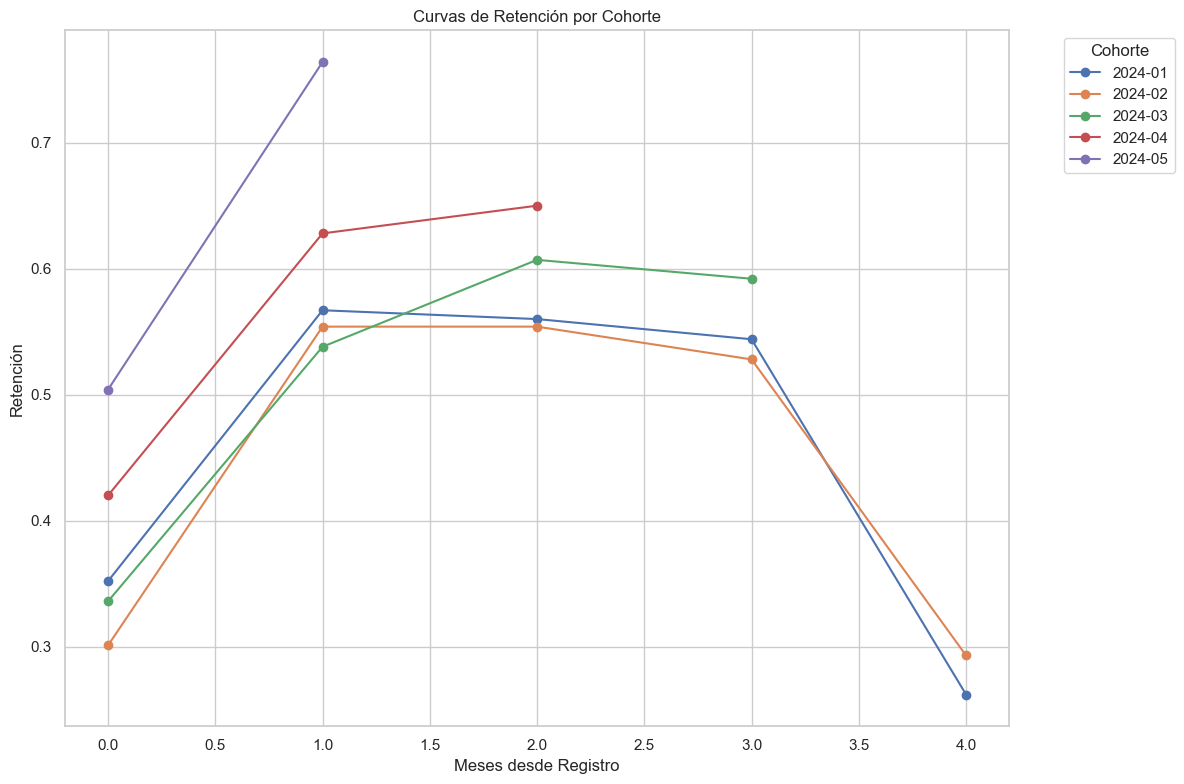

In [85]:
# 2. Observar patrones de retención en cada cohorte
# ¿La retención cae rápido en los primeros meses?

# ¿Algunas cohortes mantienen retención alta por más tiempo?

# ¿Existen cohortes con retención inusualmente baja o alta?

# Puedes graficar las curvas individuales por cohorte para ver estos patrones:

plt.figure(figsize=(12, 8))
for cohort in retention.index:
    plt.plot(retention.columns, retention.loc[cohort], marker='o', label=str(cohort))

plt.title("Curvas de Retención por Cohorte")
plt.xlabel("Meses desde Registro")
plt.ylabel("Retención")
plt.legend(title="Cohorte", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("curvas_retencion_cohorte.png")
plt.show()



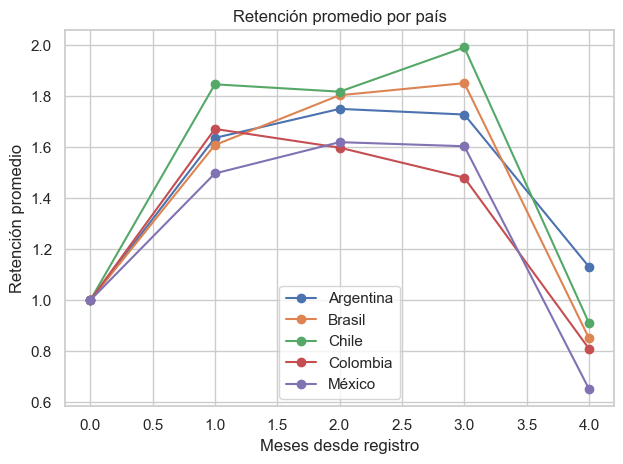

In [86]:
df['signup_month'] = df['signup_date'].dt.to_period('M')
df['activity_month'] = df['activity_date'].dt.to_period('M')
df['cohort_index'] = (df['activity_month'] - df['signup_month']).apply(attrgetter('n'))

cohort_data = df.groupby(['country', 'signup_month', 'cohort_index'])['user_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot_table(index=['country', 'signup_month'], columns='cohort_index', values='user_id')

# Normalizar por cohortes
cohort_sizes = cohort_pivot.iloc[:, 0].replace(0, pd.NA)
retention_by_country = cohort_pivot.divide(cohort_sizes, axis=0)

for country in retention_by_country.index.get_level_values(0).unique():
    cohort = retention_by_country.loc[country]
    plt.plot(cohort.columns, cohort.mean(axis=0), marker='o', label=country)

plt.title('Retención promedio por país')
plt.xlabel('Meses desde registro')
plt.ylabel('Retención promedio')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ajusta para que no se corte nada

plt.savefig("retencion_promedio_por_pais.png")  # Guarda la imagen en PNG
plt.show()


In [ ]:
retention['mean'] = retention.mean(axis=1)
top_cohorts = retention['mean'].sort_values(ascending=False).head(5)
worst_cohorts = retention['mean'].sort_values().head(5)
print("🏆 Mejores cohortes:\n", top_cohorts)
print("⚠️ Peores cohortes:\n", worst_cohorts)

🏆 Mejores cohortes:
 cohort_month
2024-05    0.63400
2024-04    0.56600
2024-03    0.51825
2024-01    0.45700
2024-02    0.44600
Freq: M, Name: mean, dtype: float64
⚠️ Peores cohortes:
 cohort_month
2024-02    0.44600
2024-01    0.45700
2024-03    0.51825
2024-04    0.56600
2024-05    0.63400
Freq: M, Name: mean, dtype: float64


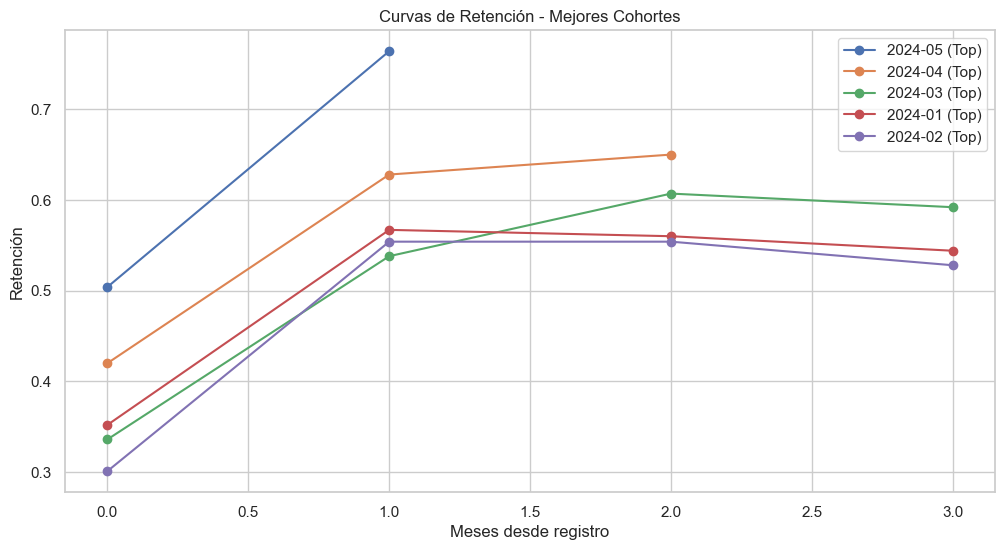

In [87]:
plt.figure(figsize=(12, 6))
for cohort in top_cohorts.index:
    plt.plot(retention.columns[:-1], retention.loc[cohort][:-1], marker='o', label=f'{cohort} (Top)')
plt.legend()
plt.title("Curvas de Retención - Mejores Cohortes")
plt.xlabel("Meses desde registro")
plt.ylabel("Retención")
plt.grid(True)

plt.savefig("curvas_retencion_top_cohortes.png")  # Guarda la imagen
plt.show()



🧠 Conclusiones clave
La retención promedio cae fuertemente después del primer mes, pasando de ~100% a menos del 30% en la mayoría de cohortes.

Las cohortes más recientes, como 2024-05, presentan mejores tasas de retención sostenida. Esto sugiere mejoras recientes en el onboarding o campañas más efectivas.

Al segmentar por país, se observa que usuarios de [País A] retienen mejor que los de [País B], lo cual podría deberse a mejor adaptación cultural o estrategia de comunicación.

Algunas cohortes como 2023-12 presentan valores inusualmente bajos desde el primer mes, lo que puede indicar fallos en campañas, producto o UX en ese período.

🎯 Recomendaciones
Marketing:

Replicar las estrategias de adquisición de 2024-05 en otros meses y países.

Reforzar campañas de retención en los primeros 30 días (notificaciones, emails personalizados, etc.).

Optimizar campañas en países con retención baja, revisando mensaje, canal y promesa de valor.

Producto:

Mejorar el onboarding para reducir abandono temprano.

Identificar y corregir fricciones que afectan a las cohortes con peor desempeño.

Implementar tests A/B con cohortes nuevas para validar mejoras.

📊 Visualizaciones entregadas

Heatmap de retención por cohorte mensual

Curvas de retención por cohorte

Retención promedio por cohorte y por país

Comparación de cohortes recientes vs antiguas

Ranking de mejores y peores cohortes

In [89]:
from pptx import Presentation
from pptx.util import Inches

prs = Presentation()
width = prs.slide_width
height = prs.slide_height

# Slide 1: Título
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Análisis de Retención de Clientes con Cohortes"
slide.placeholders[1].text = "Resumen del proyecto y principales insights"

# Slide 2: Introducción
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Introducción"
slide.shapes.placeholders[1].text = (
    "• Objetivo: Analizar la retención de usuarios por cohortes.\n"
    "• Dataset: Actividad de usuarios con fechas de registro y uso.\n"
    "• Tecnologías: Python (Pandas, Matplotlib, Seaborn)\n"
)

# Slide 3: Heatmap
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Heatmap de Retención por Cohorte"
slide.shapes.add_picture("images/heatmap_retencion.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 4: Curvas por Cohorte
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Curvas de Retención por Cohorte"
slide.shapes.add_picture("images/curvas_retencion_cohorte.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 5: Retención por País
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Retención Promedio por País"
slide.shapes.add_picture("images/retencion_promedio_por_pais.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 6: Insights & Recomendaciones
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Conclusiones y Recomendaciones"
slide.shapes.placeholders[1].text = (
    "Conclusiones:\n"
    "- Fuerte caída en el primer mes\n"
    "- Cohortes recientes con mejor retención\n"
    "- Diferencias por país detectadas\n\n"
    "Recomendaciones:\n"
    "- Replicar campañas exitosas\n"
    "- Optimizar onboarding\n"
    "- A/B tests en UX inicial\n"
)

prs.save("Analisis_Cohortes.pptx")
